
# Fairness Audit Notebook



This notebook:
- Loads and cleans borrower data
- Trains (or loads) a credit-risk model
- Computes baseline fairness metrics (Selection Rate, TPR, FPR)
- Applies ExponentiatedGradient post-processing (Equalized Odds)
- Visualizes results inline and saves plots
- Exports report to PDF via `nbconvert`

---


## Setup and imports

In [38]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds

from credit_risk.data_ingest import load_data, clean_data
from credit_risk.features import generate_features

from pathlib import Path

# find project root by climbing up until README is found
root = Path.cwd()
while not (root / "README.md").exists():
    root = root.parent
os.chdir(root)               # now CWD is project root
os.makedirs("reports", exist_ok=True)

## Load, clean, and feature-engineer data


In [39]:
df_raw = load_data("data/raw/borrowers.csv")
df_clean = clean_data(df_raw)
x_train, x_test, y_train, y_test = generate_features(df_clean)

print(f"Loaded {len(df_raw)} rows -> {len(x_train)} train, {len(x_test)} test samples")

Loaded 5 rows and 6 columns from data/raw/borrowers.csv
Dropped 0 duplicate rows
Filled missing 'employment_length' with median=7.0
Filled missing 'age' with median=45.0
Filled missing 'annual_income' with median=60000.0
Clipped 'debt_to_income' to [0,1]
One-hot encoded columns: ['emp_bin', 'age_bin']
Cleaned data has 5 rows and 16 columns
Feature generation complete: 4 training samples, 1 test samples
Stratification: on
Loaded 5 rows -> 4 train, 1 test samples


/Users/glennasher/credit-risk-project/src/credit_risk/features.py:42: UserWarning: Stratified split failed (The test_size = 1 should be greater or equal to the number of classes = 2); falling back to unstratified split.
  warnings.warn(


## Train or load model


In [40]:
# Uncomment to retrain; otherwise it loads existing
# from credit_risk.train_model import train_and_evaluate
# model_path = train_and_evaluate(x_train, x_test, y_train, y_test)
model_path = "models/best_model.joblib"
model = joblib.load(model_path)
print(f"Model loaded from {model_path}")

Model loaded from models/best_model.joblib


## Helper: Compute & plot fairness metrics


In [41]:
def compute_fairness_metrics(y_true, y_pred, groups, name):
    mf = MetricFrame(
        metrics={
            'Selection Rate': selection_rate,
            'True Positive Rate': true_positive_rate,
            'False Positive Rate': false_positive_rate
        },
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=groups
    )
    df = mf.by_group
    df.index.name = name
    return df


def plot_and_save(df, path):
    fig, axes = plt.subplots(1, df.shape[1], figsize=(5*df.shape[1], 4), sharey=True)
    if df.shape[1] == 1:
        axes = [axes]
    for ax, col in zip(axes, df.columns):
        df[col].plot(kind='bar', ax=ax, title=col)
        ax.set_xlabel(df.index.name)
        if ax is axes[0]:
            ax.set_ylabel(col)
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig(path)
    plt.show()
    print(f"Saved plot → {path}")

## Baseline fairness metrics

           Selection Rate  True Positive Rate  False Positive Rate
age_group                                                         
35-44                 1.0                 1.0                  0.0


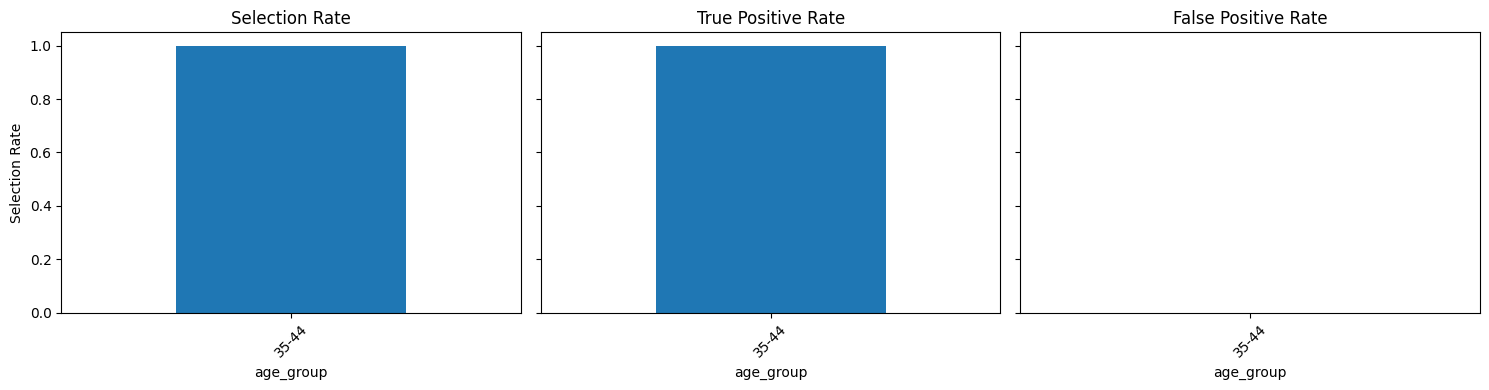

Saved plot → reports/fairness_baseline.png


In [42]:
age_bins = [18,25,35,45,55,65,100]
age_labels = ['18-24','25-34','35-44','45-54','55-64','65+']
sens = pd.cut(df_clean['age'], bins=age_bins, labels=age_labels, include_lowest=True)
sens_test = sens.loc[y_test.index].astype(str)

y_pred = model.predict(x_test)
fm_base = compute_fairness_metrics(y_test, y_pred, sens_test, 'age_group')
print(fm_base)
plot_and_save(fm_base, 'reports/fairness_baseline.png')

## Post-processing: ExponentiatedGradient (Equalized Odds)

           Selection Rate  True Positive Rate  False Positive Rate
age_group                                                         
35-44                 1.0                 1.0                  0.0


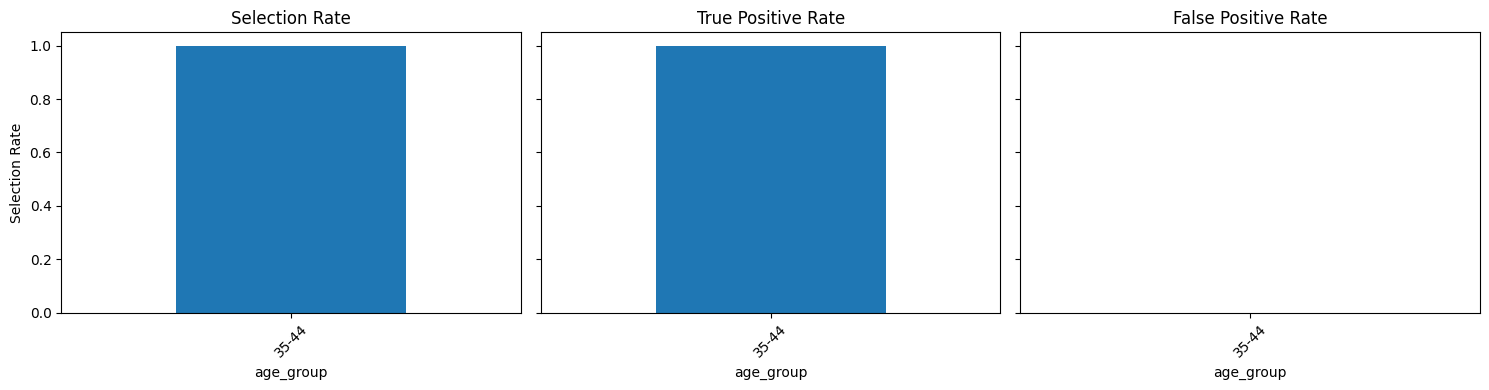

Saved plot → reports/fairness_expgrad.png


In [43]:
def apply_expgrad(est, x_tr, y_tr, x_te, groups_tr):
    mitigator = ExponentiatedGradient(
        est, constraints=EqualizedOdds(), eps=0.01, max_iter=50, sample_weight_name="clf__sample_weight"
    )
    mitigator.fit(x_tr, y_tr, sensitive_features=groups_tr)
    return mitigator.predict(x_te)

# track train grouping
sens_train = sens.loc[y_train.index].astype(str)
sens_test  = sens.loc[y_test.index].astype(str)

# apply mitigator
y_pred_opt = apply_expgrad(model, x_train, y_train, x_test, sens_train)
fm_opt = compute_fairness_metrics(y_test, y_pred_opt, sens_test, 'age_group')
print(fm_opt)
plot_and_save(fm_opt, 'reports/fairness_expgrad.png')